# 데이터 불러오기

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 경고 무시
warnings.filterwarnings('ignore')

#한글 처리를 위해 폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [2]:
df = pd.read_csv('../csv/preprocess.csv')
df.head()

,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_24h,date_of_birth_distinct_emails_4w,...,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0,0.9,0.642713,0.0,20,0.009624,105.898067,1724,7394.902554,8,...,1,0,0,1,0,0,0,1,0,0
1,0,0.9,0.720064,200.0,40,0.007018,33.006203,1986,5416.601990,5,...,1,0,0,1,0,0,0,0,1,0
2,0,0.9,0.075432,129.0,40,0.009764,-0.632448,2411,7423.819019,7,...,0,0,0,1,0,0,0,0,1,0
3,0,0.5,0.784344,240.0,20,0.017281,-1.612753,1731,4489.610329,8,...,1,0,0,1,0,1,0,0,0,0
4,0,0.8,0.770435,150.0,40,9.370346,26.733867,1863,6301.097061,7,...,0,0,0,1,0,1,0,0,0,0


# 분석

In [3]:
train_cols = df.columns[1:]
X = df[train_cols] # 독립변수
y = df["fraud_bool"] # 종속변수
df["fraud_bool"].value_counts()

0    6871
1    6871
Name: fraud_bool, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from keras import models
from keras import layers
def create_network(optimizer="rmsprop"):
    network = models.Sequential()
    network.add(layers.Dense(units=16, activation="relu", input_shape=(X.shape[1],)))
    network.add(layers.Dense(units=16, activation="relu"))
    network.add(layers.Dense(units=1, activation="sigmoid"))
    network.compile(loss='binary_crossentropy', 
                    optimizer=optimizer, # 옵티마이저 
                    metrics=["accuracy"]) # 성능 지표
    return network

In [6]:
neural_network = KerasClassifier(model=create_network, verbose=0)
# 하이퍼파라미터 탐색 영역을 정의
pipe=Pipeline([
    ('scaler', StandardScaler()),
    ('clf', neural_network)
    ])
params={
    'clf__epochs': [50, 100],
    'clf__batch_size': [32,64,128],
    'clf__optimizer': ["rmsprop", "adam"],
    }
grid=GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid_result = grid.fit(X, y)

In [7]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'clf__batch_size': 128, 'clf__epochs': 50, 'clf__optimizer': 'adam'}
0.7844563028037775


In [28]:
pred = grid_result.predict(X)

In [29]:
#confusion matrix(혼동행렬, 오분류표) 출력
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y, pred)
cm

array([[5715, 1156],
       [1274, 5597]], dtype=int64)

In [30]:
df_cm=pd.DataFrame(cm, index=[0, 1], columns=[0, 1])
df_cm

,0,1
0,5715,1156
1,1274,5597


In [35]:
tpr = df_cm.loc[0,0] / (df_cm.loc[0,0] + df_cm.loc[1,0])
fpr = df_cm.loc[0,1] / (df_cm.loc[0,1] + df_cm.loc[1,1])
precision = df_cm.loc[0,0] / (df_cm.loc[0,0] + df_cm.loc[0,1])
recall = df_cm.loc[0,0] / (df_cm.loc[0,0] + df_cm.loc[1,0])
f = (2 * (precision * recall)) / (precision + recall)
print(tpr, fpr, precision, recall, f)

0.8177135498640721 0.17118317784688286 0.831756658419444 0.8177135498640721 0.8246753246753246


In [31]:
from sklearn.metrics import classification_report
print(classification_report(y, grid_result.predict(X)))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      6871
           1       0.83      0.81      0.82      6871

    accuracy                           0.82     13742
   macro avg       0.82      0.82      0.82     13742
weighted avg       0.82      0.82      0.82     13742



# 시각화

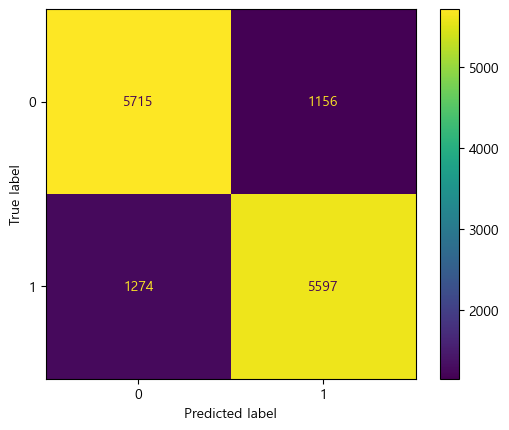

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_result.classes_).plot()

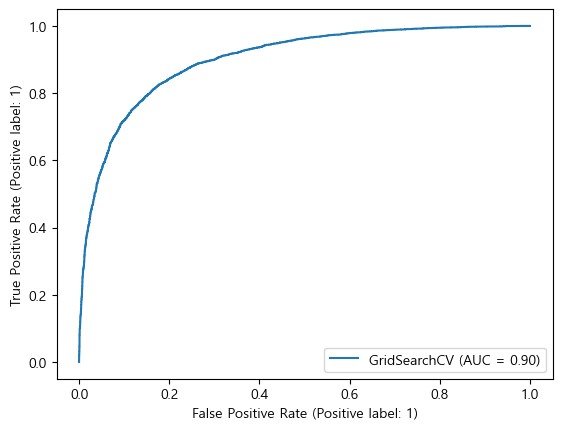

In [33]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(grid_result, X, y)
# auc = 0.90

# 저장

In [36]:
result = pd.read_csv('../csv/model_results.csv')
result

,Model,Best Score,Best Parameter,Precision,Recall,F1-score,TPR,FPR,AUC
0,KNN,0.768374,"{'clf__n_neighbors': 20, 'clf__p': 2, 'clf__we...",0.814874,0.778071,0.796047,0.778071,0.194317,0.87
1,ANN,0.745668,"{'clf__activation': 'relu', 'clf__alpha': 0.1,...",0.851841,0.848753,0.850294,0.848753,0.148700,0.93


In [37]:
if 'DNN' in result.Model.values.tolist():
    result.loc[result.Model.values.tolist().index('DNN')] = ['DNN', grid_result.best_score_, grid_result.best_params_, precision, recall, f, tpr, fpr, 0.90]
else:
    result.loc[len(result.index)] = ['DNN', grid_result.best_score_, grid_result.best_params_, precision, recall, f, tpr, fpr, 0.90]
result

,Model,Best Score,Best Parameter,Precision,Recall,F1-score,TPR,FPR,AUC
0,KNN,0.768374,"{'clf__n_neighbors': 20, 'clf__p': 2, 'clf__we...",0.814874,0.778071,0.796047,0.778071,0.194317,0.87
1,ANN,0.745668,"{'clf__activation': 'relu', 'clf__alpha': 0.1,...",0.851841,0.848753,0.850294,0.848753,0.148700,0.93
2,DNN,0.784456,"{'clf__batch_size': 128, 'clf__epochs': 50, 'c...",0.831757,0.817714,0.824675,0.817714,0.171183,0.90


In [38]:
result.to_csv('../csv/model_results.csv', index=None)

In [19]:
model = grid_result.best_estimator_['clf']

In [34]:
import joblib
joblib.dump(model, 'c:/bank_account_fraud/model/dnn.h5')

INFO:tensorflow:Assets written to: C:\Users\tjoeun\AppData\Local\Temp\tmp1is51yed\assets


['c:/bank_account_fraud/model/dnn.h5']